In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [2]:
api_key = '6feb8c26f0ebddbc4a47b6cfeac77054'
url = f'https://api.stlouisfed.org/fred/series/observations?series_id=NAEXKP01CLQ657S&api_key={api_key}&observation_start=1960-01-01&observation_end=2022-12-01&frequency=q&file_type=json'
response = requests.get(url)

In [3]:
json_data = response.json()

In [4]:
data = [(obs["date"], obs["value"]) for obs in json_data["observations"]]
df = pd.DataFrame(data, columns=["date", "Growth Rate Chile"])
df["date"] = pd.to_datetime(df["date"])
df["Growth Rate Chile"] = df["Growth Rate Chile"].astype("float")
df.index = df["date"]
df = df.drop("date", axis = 1)
df.dropna()
df

Growth Rate Chile
date                         
1995-04-01           2.757815
1995-07-01           0.489261
1995-10-01           1.839742
1996-01-01           3.079252
1996-04-01           1.184746
...                       ...
2020-10-01           6.803554
2021-01-01           3.363545
2021-04-01           1.657061
2021-07-01           4.476553
2021-10-01           1.820110

[107 rows x 1 columns]

In [5]:
df.index.freq = "QS"

Text(0, 0.5, 'Growth Rate (Percentage Variation of Real GDP)')

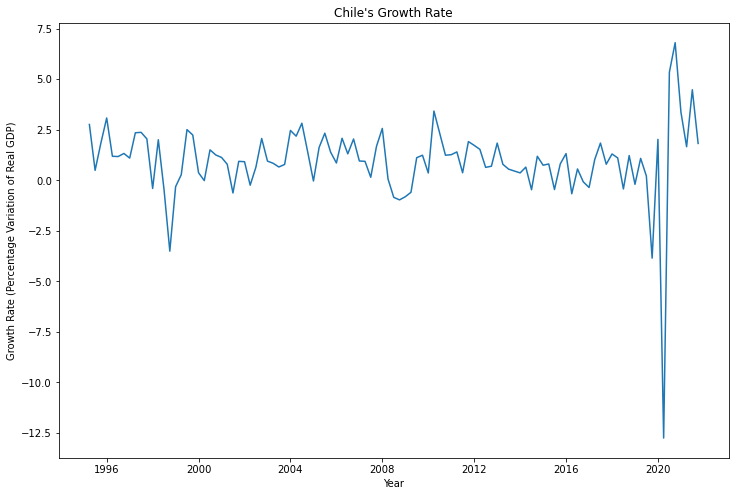

In [6]:
plt.figure(figsize=(12, 8))
plt.plot(df['Growth Rate Chile'])
plt.title("Chile's Growth Rate")
plt.xlabel('Year')
plt.ylabel('Growth Rate (Percentage Variation of Real GDP)')

In [7]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [8]:
adf_test(df['Growth Rate Chile'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.010598e+01
p-value                 1.029714e-17
# lags used             0.000000e+00
# observations          1.060000e+02
critical value (1%)    -3.493602e+00
critical value (5%)    -2.889217e+00
critical value (10%)   -2.581533e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [9]:
len(df)

107

In [10]:
q_80 = int(len(df) * .8)

In [11]:
y_train = df["Growth Rate Chile"].iloc[:q_80]
y_test = df["Growth Rate Chile"].iloc[q_80:]

<AxesSubplot:xlabel='date'>

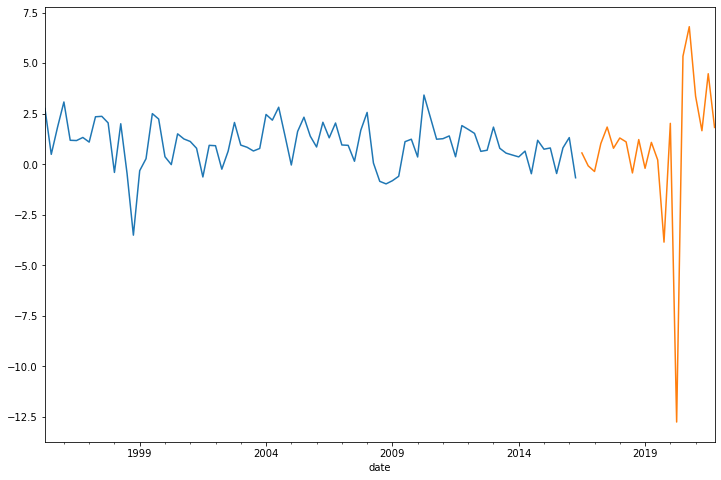

In [12]:
y_train.plot(figsize = (12, 8))
y_test.plot()

In [13]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [14]:
model = auto_arima(y_train, trace = True, seasonal = True, m = 4)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=256.292, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=261.151, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=254.949, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=252.749, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=310.136, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=251.462, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=253.030, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[4] intercept   : AIC=250.726, Time=0.09 sec
 ARIMA(0,0,1)(2,0,1)[4] intercept   : AIC=251.141, Time=0.09 sec
 ARIMA(0,0,1)(1,0,2)[4] intercept   : AIC=251.449, Time=0.15 sec
 ARIMA(0,0,1)(0,0,2)[4] intercept   : AIC=250.291, Time=0.05 sec
 ARIMA(0,0,0)(0,0,2)[4] intercept   : AIC=258.876, Time=0.05 sec
 ARIMA(1,0,1)(0,0,2)[4] intercept   : AIC=252.282, Time=0.09 sec
 ARIMA(0,0,2)(0,0,2)[4] intercept   : AIC=252.284, Time=0.05 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=251.5

Potential models are: 
- ARIMA(0,0,1)x(0,0,2,4)
- ARIMA(0,0,1)x(1,0,1,4)
- ARIMA(0,0,1)x(2,0,1,4)
- ARIMA(0,0,1)x(1,0,2,4)

In [15]:
model_list = {"order": [(0, 0, 1), (0, 0, 1), (0, 0 ,1), (0, 0 ,1)], "seasonal_order": [(0,0,2,4), (1,0,1,4), (2,0,1,4), (1,0,2,4)]}

In [16]:
from statsmodels.tools.eval_measures import rmse

In [17]:
metrics = pd.DataFrame(data = {"Order" : [], "Seasonal Order": [], "AIC": [], "BIC" : [], "RMSE": []})
for order, seasonal_order in zip(model_list["order"], model_list["seasonal_order"]):
    model= SARIMAX(y_train, order = order, seasonal_order = seasonal_order, enforce_invertibility = True, trend = "c").fit()
   
    start = len(y_train)
    end = len(y_train) + len(y_test) -1
    
    y_pred = model.predict(start, end)
    rmse_model = rmse(y_test, y_pred)
    
    metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC": model.aic, "BIC" : model.bic, "RMSE": rmse_model}, ignore_index = True)

C:\Users\User\AppData\Local\Temp\ipykernel_14912\2691938010.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC": model.aic, "BIC" : model.bic, "RMSE": rmse_model}, ignore_index = True)
C:\Users\User\AppData\Local\Temp\ipykernel_14912\2691938010.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC": model.aic, "BIC" : model.bic, "RMSE": rmse_model}, ignore_index = True)
C:\Users\User\AppData\Local\Temp\ipykernel_14912\2691938010.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC"

In [18]:
metrics = metrics.sort_values("RMSE")
metrics

Order Seasonal Order         AIC         BIC      RMSE
0  (0, 0, 1)   (0, 0, 2, 4)  250.290974  262.504230  3.653263
1  (0, 0, 1)   (1, 0, 1, 4)  250.725657  262.938913  3.660083
3  (0, 0, 1)   (1, 0, 2, 4)  251.448761  266.104668  3.665176
2  (0, 0, 1)   (2, 0, 1, 4)  251.140940  265.796847  3.669831

The best model is SARIMA(0,0,1)x(0,0,2,4)

<AxesSubplot:xlabel='date'>

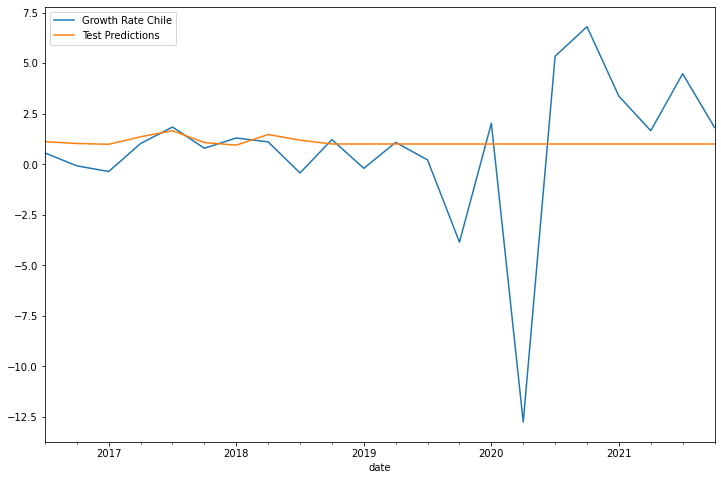

In [19]:
selected_model = SARIMAX(y_train, order = metrics["Order"].iloc[0], seasonal_order = metrics["Seasonal Order"].iloc[0], enforce_invertibility = True, trend = "c").fit()
y_hat_test = selected_model.predict(start, end).rename("Test Predictions")
plt.figure(figsize = (12, 8))
y_test.plot(legend = True)
y_hat_test.plot(legend = True)

In [20]:
final_model =  SARIMAX(df["Growth Rate Chile"], order = metrics["Order"].iloc[0], seasonal_order = metrics["Seasonal Order"].iloc[0], enforce_invertibility = True, trend = "c").fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                      Growth Rate Chile   No. Observations:                  107
Model:             SARIMAX(0, 0, 1)x(0, 0, [1, 2], 4)   Log Likelihood                -220.337
Date:                                Fri, 02 Jun 2023   AIC                            450.675
Time:                                        01:02:31   BIC                            464.039
Sample:                                    04-01-1995   HQIC                           456.093
                                         - 10-01-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9202      0.172      5.363      0.000       0.584       1.256
ma.L1         -0.0114      0.069     -0.167      0.868      -0.146       0.123
ma.S.L4       -0.1302      0.113     -1.157      0.247      -0.351       0.090
ma.S.L8       -0.2429      0.284     -0.854      0.393      -0.800       0.315
sigma2         3.5784      0.203     17.592      0.000       3.180       3.977
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2898.08
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.62   Skew:                            -3.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
forecast_size = 4

In [22]:
final_order  = metrics["Order"].iloc[0]
final_seasonal_order = metrics["Seasonal Order"].iloc[0]

In [23]:
y_forecast = final_model.predict(start = len(df), end = len(df) + forecast_size - 1, typ = "levels").rename(f"SARIMA{final_order}x{final_seasonal_order} Forecast")

<AxesSubplot:xlabel='date'>

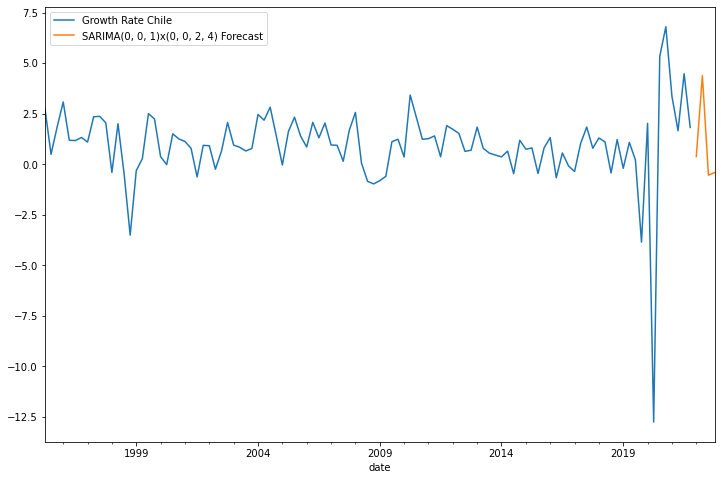

In [24]:
plt.figure(figsize = (12, 8))
df["Growth Rate Chile"].plot(legend = True)
y_forecast.plot(legend = True)

<AxesSubplot:xlabel='date'>

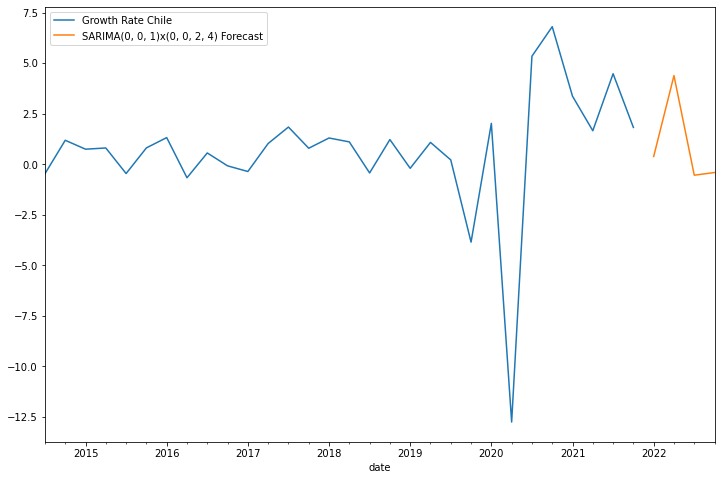

In [25]:
plt.figure(figsize = (12, 8))
df["Growth Rate Chile"].iloc[-30:].plot(legend = True)
y_forecast.plot(legend = True)

In [26]:
y_forecast

2022-01-01    0.382175
2022-04-01    4.384326
2022-07-01   -0.542176
2022-10-01   -0.410822
Freq: QS-JAN, Name: SARIMA(0, 0, 1)x(0, 0, 2, 4) Forecast, dtype: float64